# 数据探索

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import networkx as nx
from scipy import stats
import re

In [2]:
data_dir = "abide1/"
roi_file = "x_dosenbach.csv"
data_info = "abide1info.csv"

## 1. 预处理

In [3]:
# 加载相关性矩阵数据
def load_fc_matrices(data_dir="hx/"):
    fc_files = glob(os.path.join(data_dir, "*.txt"))
    
    # 提取分组和ID信息
    data = []
    for file in fc_files:
        filename = os.path.basename(file)
        if "ASD" in filename:
            group = "ASD"
            # 提取四位数字ID
            id_match = re.search(r'zASD(\d{5})', filename)
            if id_match:
                subject_id = id_match.group(1)
            else:
                continue
        elif "TC" in filename:
            group = "TC"
            # 提取三位数字ID
            id_match = re.search(r'zTC(\d{5})', filename)
            if id_match:
                subject_id = id_match.group(1)
            else:
                continue
        else:
            continue
        
        # 加载FC矩阵
        fc_matrix = np.loadtxt(file)
        if fc_matrix.shape == (160, 160):  # 确保维度正确
            data.append({
                'subject_id': subject_id,
                'group': group,
                'fc_matrix': fc_matrix,
                'filename': filename
            })
    
    return data

# 加载ROI信息
def load_roi_info(file_path=roi_file):
    roi_info = pd.read_csv(file_path)
    roi_info = roi_info.iloc[:160]
    return roi_info

# 加载个体信息
def load_subject_info(file_path=data_info):
    subject_info = pd.read_csv(file_path)  
    return subject_info

In [4]:
# 加载所有数据
fc_data = load_fc_matrices(data_dir)
roi_info = load_roi_info()
subject_info = load_subject_info()

# 查看数据基本信息
print(f"加载的FC矩阵数量: {len(fc_data)}")
print(f"ASD组数量: {sum(1 for d in fc_data if d['group'] == 'ASD')}")
print(f"TC组数量: {sum(1 for d in fc_data if d['group'] == 'TC')}")
print("\nROI信息前5行:")
print(roi_info.head())
print(f"个体信息数量: {len(subject_info)}")

加载的FC矩阵数量: 192
ASD组数量: 88
TC组数量: 104

ROI信息前5行:
   Labels           Regions Hemishpere Subnetwork  x(mm)  y(mm)  z(mm)
0       1  vmPFC                     R    default      6     64      3
1       2  mPFC                    NaN    default      0     51     32
2       3  aPFC                      L    default    -25     51     27
3       4  vmPFC                     R    default      9     51     16
4       5  vmPFC                     L    default     -6     50     -1
个体信息数量: 715


- 如果要稀疏化，尝试：
    1. 阈值法
    2. 影响力参数计算

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def compute_mean_fc(fc_data):
    fc_stack = np.stack([d['fc_matrix'] for d in fc_data])
    return np.mean(fc_stack, axis=0)

def build_roi_labels(roi_info, target_network='default'):
    """
    将每个ROI根据其所属网络转为标签：属于目标网络为1，否则为0
    """
    labels = (roi_info['Subnetwork'] == target_network).astype(int).values
    return labels

def forward_select_influential_rois(avg_fc_matrix, roi_labels, max_steps=15):
    """
    前向选择过程：在每一步选择一个新的ROI，使得能更好区分是否属于目标子网络
    """
    n_rois = avg_fc_matrix.shape[0]
    selected = []
    remaining = list(range(n_rois))
    influence_weights = np.zeros(n_rois)

    for step in range(max_steps):
        best_roi = None
        best_loss = np.inf
        best_model = None
        
        for j in remaining:
            candidate_rois = selected + [j]
            X = avg_fc_matrix[:, candidate_rois]  # ROI的连接模式
            y = roi_labels

            # 训练逻辑回归模型
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
            model.fit(X, y)
            y_prob = model.predict_proba(X)[:, 1]
            loss = log_loss(y, y_prob)

            if loss < best_loss:
                best_loss = loss
                best_roi = j
                best_model = model

        if best_roi is not None:
            selected.append(best_roi)
            remaining.remove(best_roi)
            influence_weights[best_roi] = np.abs(best_model.coef_[0][-1])  # 当前加进来的那一项权重
            
        if best_loss > 1e-4 :
            print(f"Step {step+1}: selected ROI {best_roi}, loss = {best_loss:.4f}" )
    
    return selected, influence_weights


In [6]:
avg_fc_matrix = compute_mean_fc(fc_data)  # 160 x 160
roi_labels = build_roi_labels(roi_info, target_network="default")  # 0/1 标签

selected_rois, influence_scores = forward_select_influential_rois(avg_fc_matrix, roi_labels, max_steps=15)

# 输出Top重要ROI
a = 30
top_indices = np.argsort(influence_scores)[::-1][:a]
print(f"Top influential ROIs for 'Default' network :")
for idx in top_indices:
    if influence_scores[idx] >0 :
        print(f"ROI {idx}: {roi_info.iloc[idx]['Labels']} ({roi_info.iloc[idx]['Subnetwork']}), influence = {influence_scores[idx]:.4f}")


Step 1: selected ROI 24, loss = 0.1703
Step 2: selected ROI 22, loss = 0.1182
Step 3: selected ROI 93, loss = 0.0843
Step 4: selected ROI 6, loss = 0.0630
Step 5: selected ROI 2, loss = 0.0303
Top influential ROIs for 'Default' network :
ROI 125: 126 (occipital), influence = 1900.2205
ROI 16: 17 (default), influence = 308.9307
ROI 78: 79 (cingulo-opercular), influence = 261.0166
ROI 141: 142 (occipital), influence = 128.4901
ROI 33: 34 (default), influence = 122.4427
ROI 152: 153 (cerebellum), influence = 117.7143
ROI 62: 63 (cingulo-opercular), influence = 116.0594
ROI 124: 125 (occipital), influence = 72.6605
ROI 156: 157 (cerebellum), influence = 71.3758
ROI 93: 94 (sensorimotor), influence = 33.3082
ROI 2: 3 (default), influence = 22.9127
ROI 24: 25 (default), influence = 18.5443
ROI 6: 7 (default), influence = 18.5266
ROI 22: 23 (default), influence = 12.5951
ROI 139: 140 (occipital), influence = 0.6831


In [7]:
# 1. 初始化稀疏矩阵
fc_sparse_by_influence = np.zeros_like(avg_fc_matrix)

# 2. 获取所有子网络名
subnetworks = roi_info['Subnetwork'].unique()

# 3. 针对每个子网络运行影响因子提取 & 稀疏化
for net in subnetworks:
    print(f"\n>> Processing subnetwork: {net}")
    
    roi_labels = build_roi_labels(roi_info, target_network=net)
    selected_rois, influence_scores = forward_select_influential_rois(avg_fc_matrix, roi_labels, max_steps=15)

    # 确定影响力大于0的节点
    influential_rois = np.where(influence_scores > 0)[0]
    
    # 对这些ROI保留其在 FC 中的边，其余设为0
    for roi in influential_rois:
        fc_sparse_by_influence[roi, :] += avg_fc_matrix[roi, :]
        fc_sparse_by_influence[:, roi] += avg_fc_matrix[:, roi]

# 4. 为了不重复加边（由于上面对称加了两次），我们除以2
fc_sparse_by_influence = fc_sparse_by_influence / 2.0



>> Processing subnetwork: default
Step 1: selected ROI 24, loss = 0.1703
Step 2: selected ROI 22, loss = 0.1182
Step 3: selected ROI 93, loss = 0.0843
Step 4: selected ROI 6, loss = 0.0630
Step 5: selected ROI 2, loss = 0.0303

>> Processing subnetwork: fronto-parietal
Step 1: selected ROI 50, loss = 0.1640
Step 2: selected ROI 37, loss = 0.1190
Step 3: selected ROI 36, loss = 0.0633
Step 4: selected ROI 146, loss = 0.0368

>> Processing subnetwork: cingulo-opercular
Step 1: selected ROI 66, loss = 0.3711
Step 2: selected ROI 80, loss = 0.3227
Step 3: selected ROI 78, loss = 0.2778
Step 4: selected ROI 107, loss = 0.2348
Step 5: selected ROI 69, loss = 0.1817
Step 6: selected ROI 83, loss = 0.1463
Step 7: selected ROI 70, loss = 0.1227
Step 8: selected ROI 99, loss = 0.1013
Step 9: selected ROI 0, loss = 0.0689
Step 10: selected ROI 106, loss = 0.0361

>> Processing subnetwork: sensorimotor
Step 1: selected ROI 107, loss = 0.2178
Step 2: selected ROI 30, loss = 0.1299
Step 3: selected

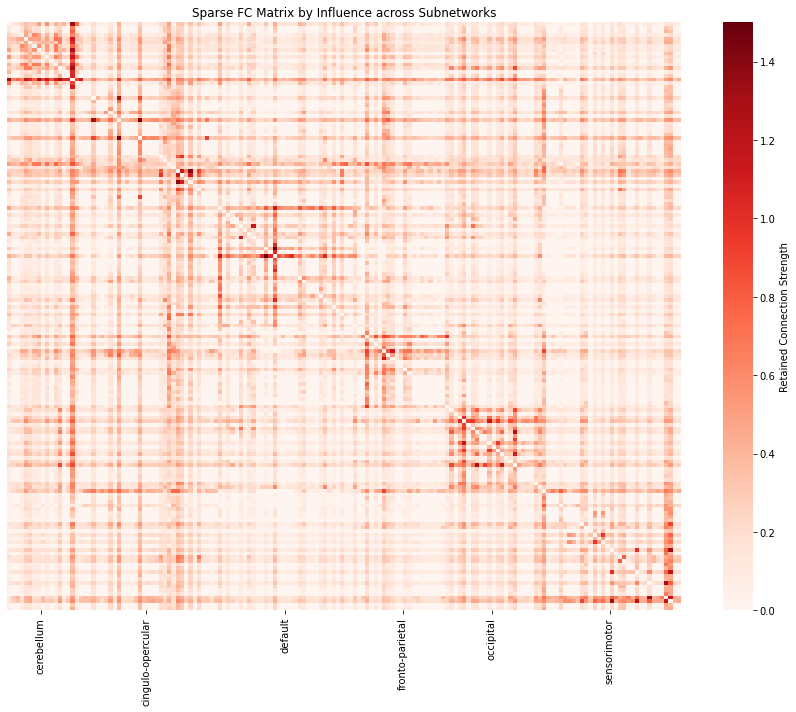

In [8]:
# 重新排序矩阵和标签
roi_order = roi_info.sort_values('Subnetwork').index
sorted_matrix = fc_sparse_by_influence[np.ix_(roi_order, roi_order)]
sorted_labels = roi_info.iloc[roi_order]['Subnetwork'].values

# 准备坐标轴子网络名称仅显示一次
import matplotlib.ticker as ticker

# 获取每个子网络开始的索引位置，用于设置tick和划线
subnetworks = roi_info.iloc[roi_order]['Subnetwork'].values
unique_subnetworks = pd.unique(subnetworks)
network_boundaries = [np.where(subnetworks == net)[0][0] for net in unique_subnetworks]

# 开始绘图
plt.figure(figsize=(12, 10))
ax = sns.heatmap(sorted_matrix,
                 cmap='Reds',  # 单向色带
                 vmin=0, vmax=1.5,  # 映射范围
                 xticklabels=False, yticklabels=False,
                 cbar_kws={'label': 'Retained Connection Strength'})

# 设置 x 轴上只显示一次子网络名（居中显示）
tick_positions = [(np.where(subnetworks == net)[0][0] + np.where(subnetworks == net)[0][-1]) // 2 for net in unique_subnetworks]
ax.set_xticks(tick_positions)
ax.set_xticklabels(unique_subnetworks, rotation=90)
ax.set_yticks([])

plt.title('Sparse FC Matrix by Influence across Subnetworks')
plt.tight_layout()
plt.show()


# 2. 矩阵可视化与网络结构分析

- 被试FC热力图

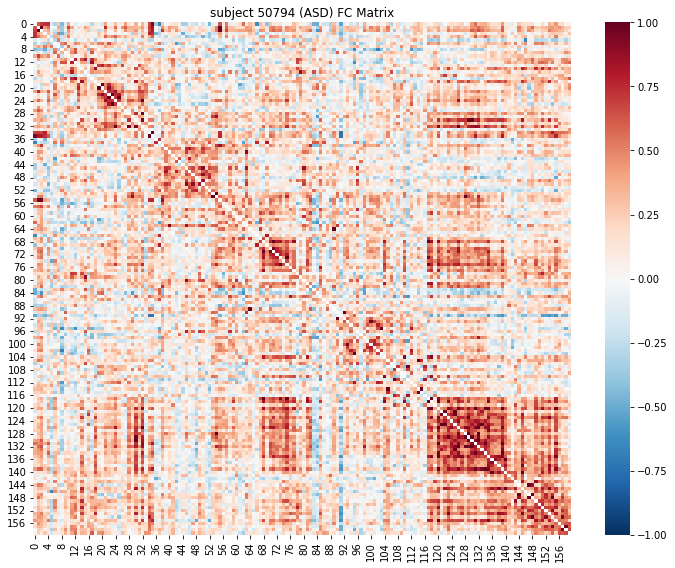

In [9]:
def plot_fc_matrix_heatmap(fc_matrix, title="功能连接矩阵热力图", mask_diagonal=True):
    """
    绘制FC矩阵的热力图
    
    参数:
    fc_matrix: 160x160的连接矩阵
    title: 图表标题
    mask_diagonal: 是否掩盖对角线
    """
    plt.figure(figsize=(10, 8))
    
    # 创建对角线掩码
    mask = None
    if mask_diagonal:
        mask = np.zeros_like(fc_matrix, dtype=bool)
        np.fill_diagonal(mask, True)
    
    # 绘制热力图
    sns.heatmap(fc_matrix, 
                cmap="RdBu_r", 
                center=0,
                mask=mask,
                vmin=-1, vmax=1)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 示例：绘制被试的FC矩阵热力图
sample_subject = fc_data[0]
subject_id = sample_subject['subject_id']
group = sample_subject['group']
plot_fc_matrix_heatmap(
    sample_subject['fc_matrix'], 
    title=f"subject {subject_id} ({group}) FC Matrix"
)


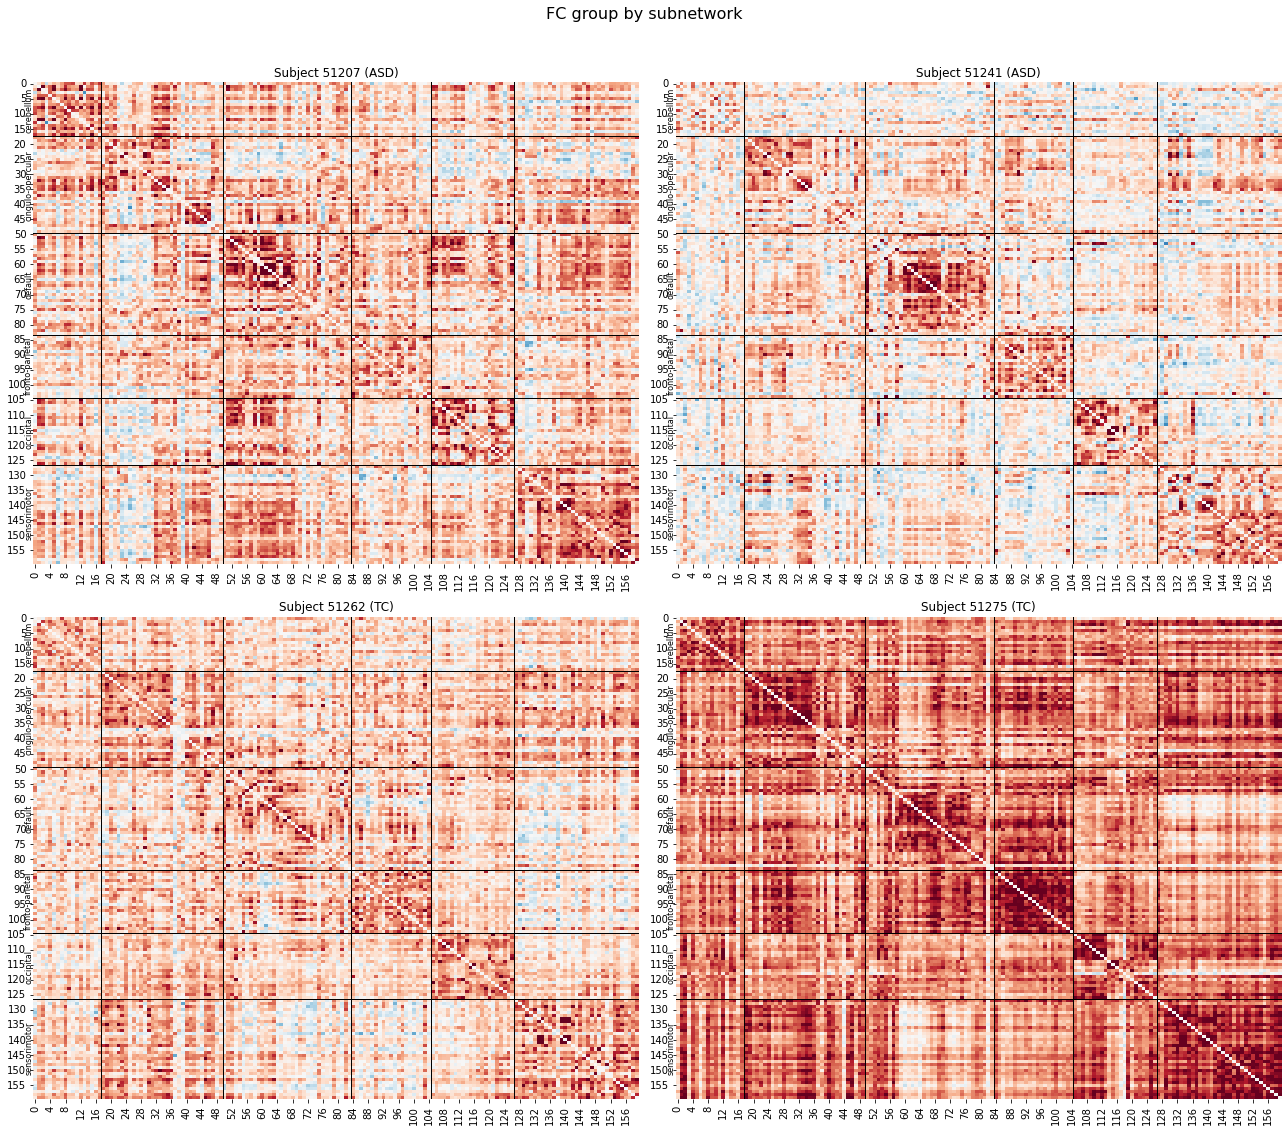

子网络列表: ['cerebellum', 'cingulo-opercular', 'default', 'fronto-parietal', 'occipital', 'sensorimotor']


In [10]:
def plot_fc_by_subnetworks(fc_matrix, roi_info, title="FC group by subnetwork", ax=None, show_colorbar=True):
    """
    根据子网络重排序并绘制FC矩阵热力图
    
    参数:
    fc_matrix: 功能连接矩阵
    roi_info: 包含ROI信息的DataFrame
    title: 图表标题
    ax: matplotlib轴对象，用于子图布局
    show_colorbar: 是否显示颜色条
    """
    # 按子网络对ROI排序
    sorted_indices = roi_info.sort_values('Subnetwork').index.values
    sorted_matrix = fc_matrix[sorted_indices, :][:, sorted_indices]
    
    # 获取排序后的子网络名称
    subnetworks = roi_info.iloc[sorted_indices]['Subnetwork'].values
    unique_subnetworks = []
    for s in subnetworks:
        if s not in unique_subnetworks:
            unique_subnetworks.append(s)
    
    # 找出子网络边界和每个子网络的大小
    boundaries = []
    network_sizes = []
    current_network = subnetworks[0]
    current_size = 0
    
    for i, network in enumerate(subnetworks):
        if network != current_network:
            boundaries.append(i)
            network_sizes.append(current_size)
            current_network = network
            current_size = 1
        else:
            current_size += 1
    
    # 添加最后一个子网络的大小
    network_sizes.append(current_size)
    
    # 创建一个用于标记子网络的矩阵
    n = len(sorted_matrix)
    network_labels = np.zeros((n, n))
    
    # 为每个子网络分配唯一的标签值
    start_idx = 0
    for i, size in enumerate(network_sizes):
        end_idx = start_idx + size
        network_labels[start_idx:end_idx, start_idx:end_idx] = i + 1
        start_idx = end_idx
    
    # 确定是创建新图还是使用提供的轴
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    
    # 绘制热力图
    im = sns.heatmap(sorted_matrix, cmap="RdBu_r", center=0, vmin=-1, vmax=1, 
                 cbar=show_colorbar, ax=ax)
    
    # 为不同子网络区域添加背景色标记
    # 使用微妙的背景色，避免干扰FC值的可视化
    cmap = plt.cm.Pastel1
    network_colors = [cmap(i) for i in np.linspace(0, 1, len(unique_subnetworks))]
    
    # 添加子网络边界线
    for b in boundaries:
        ax.axhline(y=b, color='black', linewidth=1.0)
        ax.axvline(x=b, color='black', linewidth=1.0)
    
    # 添加子网络标签
    start_idx = 0
    for i, (network, size) in enumerate(zip(unique_subnetworks, network_sizes)):
        # 在子网络中间位置添加标签
        mid_point = start_idx + size // 2
        
        # 在顶部和左侧添加标签
        ax.text(-0.01, mid_point, network, 
                rotation=90, verticalalignment='center', 
                horizontalalignment='right', fontsize=8)
        
        # 更新起始索引
        start_idx += size
    
    ax.set_title(title)
    
    return unique_subnetworks, boundaries, network_sizes

# 2x2布局对比多个主体的FC矩阵
def plot_multiple_fc_comparison(subjects_indices, fc_data, roi_info, figsize=(18, 16)):
    """
    在2x2布局中比较多个被试的FC矩阵
    
    参数:
    subjects_indices: 要比较的被试索引列表（最多4个）
    fc_data: FC矩阵数据列表
    roi_info: ROI信息DataFrame
    figsize: 图形大小
    """
    if len(subjects_indices) > 4:
        subjects_indices = subjects_indices[:4]
        print("警告: 最多只能比较4个被试，已取前4个")
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # 为未使用的轴设置不可见
    for i in range(len(subjects_indices), 4):
        axes[i].set_visible(False)
    
    # 处理每个被试的数据
    for i, subject_idx in enumerate(subjects_indices):
        if subject_idx < len(fc_data):
            subject = fc_data[subject_idx]
            title = f"Subject {subject['subject_id']} ({subject['group']})"
            
            networks, _, _ = plot_fc_by_subnetworks(
                subject['fc_matrix'], 
                roi_info,
                title=title,
                ax=axes[i],
                show_colorbar=False
            )
    
    # 添加一个总标题
    plt.suptitle("FC group by subnetwork", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect参数为了给顶部标题留空间
    plt.show()
    
    return networks

# 示例使用：比较4个被试
# 假设我们至少有4个被试数据
num_subjects = min(4, len(fc_data))
subject_indices = list([77,115,137,150])
networks = plot_multiple_fc_comparison(subject_indices, fc_data, roi_info)
print("子网络列表:", networks)


- 年龄分组

In [11]:
def match_subjects_with_age(fc_data, info_df):
    asd_matrices = []
    tc_matrices = []
    
    for subject in fc_data:
        subject_id = subject['subject_id']
        group = subject['group']
        
        # 尝试在info_df中找到匹配的ID
        # info_df中ID格式为"ASDxxxx"或"TDxxx"，而subject_id仅包含数字部分
        if group == 'ASD':
            matches = info_df[info_df['SUB_ID'].astype(str)==subject_id]
            if len(matches) > 0:
                age = matches['AGE_AT_SCAN'].values[0]
                asd_matrices.append({
                    'id': subject_id,
                    'age': age,
                    'matrix': subject['fc_matrix'],
                    'diagnosis':'ASD'
                })
        elif group == 'TC':
            matches = info_df[info_df['SUB_ID'].astype(str)==subject_id]
            if len(matches) > 0:
                age = matches['AGE_AT_SCAN'].values[0]
                tc_matrices.append({
                    'id': subject_id,
                    'age': age,
                    'matrix': subject['fc_matrix'],
                    'diagnosis':'TC'
                })
    
    print(f"ASD组匹配到年龄信息: {len(asd_matrices)}人")
    print(f"TC组匹配到年龄信息: {len(tc_matrices)}人")
    
    return asd_matrices, tc_matrices
asd_data, tc_data = match_subjects_with_age(fc_data, subject_info)

ASD组匹配到年龄信息: 88人
TC组匹配到年龄信息: 104人


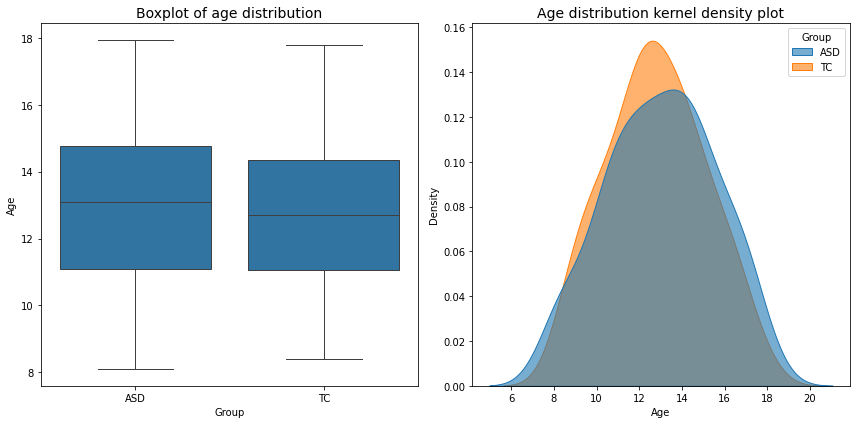

组间年龄t检验结果: t=0.704, p=0.482
ASD组 (n=88): 平均年龄=13.02岁, 标准差=2.52
TC组 (n=104): 平均年龄=12.78岁, 标准差=2.30


In [12]:
# 1. 年龄分布可视化 - 比较ASD组和TD组的年龄分布
def visualize_age_distribution(asd_data, tc_data):
    # 提取年龄数据
    asd_ages = [subj['age'] for subj in asd_data]
    tc_ages = [subj['age'] for subj in tc_data]
    
    # 创建DataFrame用于seaborn绘图
    df_ages = pd.DataFrame({
        'Age': asd_ages + tc_ages,
        'Group': ['ASD'] * len(asd_ages) + ['TC'] * len(tc_ages)
    })
    
    # 绘制年龄分布
    plt.figure(figsize=(12, 6))
    
    # 左边：箱线图
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Group', y='Age', data=df_ages)
    plt.title('Boxplot of age distribution', fontsize=14)
    
    # 右边：核密度图
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df_ages, x='Age', hue='Group', fill=True, common_norm=False, alpha=0.6)
    plt.title('Age distribution kernel density plot', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 进行t检验比较年龄是否有显著差异
    t_stat, p_val = stats.ttest_ind(asd_ages, tc_ages)
    print(f"组间年龄t检验结果: t={t_stat:.3f}, p={p_val:.3f}")
    print(f"ASD组 (n={len(asd_ages)}): 平均年龄={np.mean(asd_ages):.2f}岁, 标准差={np.std(asd_ages):.2f}")
    print(f"TC组 (n={len(tc_ages)}): 平均年龄={np.mean(tc_ages):.2f}岁, 标准差={np.std(tc_ages):.2f}")
    
    return df_ages

age_df = visualize_age_distribution(asd_data, tc_data)

- 年龄区间热力图对比

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox

def create_age_window_visualization(asd_data, tc_data):
    """
    创建一个交互式年龄窗口可视化工具，比较不同年龄段ASD和TC组FC矩阵
    """
    # 获取所有被试的年龄范围
    all_ages = [subj['age'] for subj in asd_data + tc_data]
    min_age, max_age = min(all_ages), max(all_ages)
    
    # 创建输出区域
    output = widgets.Output()
    
    # 创建年龄滑动条和输入框
    age_slider = widgets.FloatRangeSlider(
        value=[min_age, min_age+5],
        min=min_age,
        max=max_age,
        step=0.5,
        description='年龄范围:',
        layout=widgets.Layout(width='60%')
    )
    
    age_min_input = widgets.BoundedFloatText(
        value=min_age,
        min=min_age,
        max=max_age-1,
        step=0.5,
        description='最小:',
        layout=widgets.Layout(width='20%')
    )
    
    age_max_input = widgets.BoundedFloatText(
        value=min_age+5,
        min=min_age+1,
        max=max_age,
        step=0.5,
        description='最大:',
        layout=widgets.Layout(width='20%')
    )
    
    # 同步滑动条和输入框
    def update_range_slider(*args):
        age_slider.value = (age_min_input.value, age_max_input.value)
        
    def update_text_inputs(*args):
        age_min_input.value = age_slider.value[0]
        age_max_input.value = age_slider.value[1]
    
    age_min_input.observe(update_range_slider, 'value')
    age_max_input.observe(update_range_slider, 'value')
    age_slider.observe(update_text_inputs, 'value')
    
    # 创建色标范围和显示选项控件
    vmin_input = widgets.FloatSlider(
        value=-0.5,
        min=-1,
        max=1,
        step=0.1,
        description='色标最小值:',
        layout=widgets.Layout(width='45%')
    )
    
    vmax_input = widgets.FloatSlider(
        value=0.5,
        min=-1,
        max=1,
        step=0.1,
        description='色标最大值:',
        layout=widgets.Layout(width='45%')
    )
    
    display_diff = widgets.Checkbox(
        value=False,
        description='显示差异矩阵',
        layout=widgets.Layout(width='30%')
    )
    
    cmap_dropdown = widgets.Dropdown(
        options=['coolwarm', 'RdBu_r', 'seismic', 'viridis', 'plasma', 'inferno'],
        value='RdBu_r',
        description='颜色映射:',
        layout=widgets.Layout(width='30%')
    )
    
    # 绘图按钮
    plot_button = widgets.Button(
        description='生成热力图',
        button_style='success',
        layout=widgets.Layout(width='20%')
    )
    
    # 布局
    controls_upper = HBox([age_slider])
    controls_middle = HBox([age_min_input, age_max_input, vmin_input, vmax_input])
    controls_lower = HBox([display_diff, cmap_dropdown])
    controls_all = VBox([controls_upper, controls_middle, controls_lower, plot_button, output])

    # 计算矩阵维度
    matrix_dim = asd_data[0]['matrix'].shape[0] if asd_data else tc_data[0]['matrix'].shape[0]

    def plot_heatmap(age_min, age_max, vmin, vmax, display_diff, cmap):
        with output:
            output.clear_output()
            if age_max <= age_min:
                print("错误: 最大年龄必须大于最小年龄")
                return

            # 筛选年龄范围内的被试
            asd_in_range = [subj for subj in asd_data if age_min <= subj['age'] <= age_max]
            tc_in_range = [subj for subj in tc_data if age_min <= subj['age'] <= age_max]

            if not asd_in_range or not tc_in_range:
                print(f"警告: 在{age_min}-{age_max}年龄范围内没有足够的被试数据")
                print(f"ASD组: {len(asd_in_range)}人, TC组: {len(tc_in_range)}人")
                return

            # 计算平均矩阵
            asd_avg_matrix = np.mean([subj['matrix'] for subj in asd_in_range], axis=0)
            tc_avg_matrix = np.mean([subj['matrix'] for subj in tc_in_range], axis=0)

            # 创建图形
            if display_diff:
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                diff_matrix = asd_avg_matrix - tc_avg_matrix
                titles = ['ASD', 'TC', 'ASD-TC']
                matrices = [asd_avg_matrix, tc_avg_matrix, diff_matrix]
            else:
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                titles = ['ASD avg', 'TC avg']
                matrices = [asd_avg_matrix, tc_avg_matrix]

            # 绘制热力图
            for i, (title, matrix) in enumerate(zip(titles, matrices)):
                im = axes[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
                axes[i].set_title(f"{title} (n={len(asd_in_range if i==0 else tc_in_range)})")
                axes[i].set_xlabel('ROI')
                axes[i].set_ylabel('ROI')

            # 添加颜色条
            cbar = fig.colorbar(im, ax=axes, shrink=0.8)
            cbar.set_label('r')

            # 设置标题
            plt.suptitle(f'age {age_min:.1f}-{age_max:.1f} FC', fontsize=16)

            # 添加被试信息
            asd_ages = [subj['age'] for subj in asd_in_range]
            tc_ages = [subj['age'] for subj in tc_in_range]

            info_text = (
                f"ASD: n={len(asd_in_range)}, age_avg: {np.mean(asd_ages):.2f}±{np.std(asd_ages):.2f}\n"
                f"TC: n={len(tc_in_range)}, age_avg: {np.mean(tc_ages):.2f}±{np.std(tc_ages):.2f}"
            )
            plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=12)

            plt.show()

            # 返回当前窗口内的数据，以便进一步分析
            return {
                'age_range': (age_min, age_max),
                'asd_subjects': asd_in_range,
                'tc_subjects': tc_in_range,
                'asd_avg_matrix': asd_avg_matrix,
                'tc_avg_matrix': tc_avg_matrix,
                'diff_matrix': asd_avg_matrix - tc_avg_matrix if display_diff else None
            }

    def on_plot_button_clicked(b):
        plot_heatmap(age_min_input.value, age_max_input.value, vmin_input.value, vmax_input.value, display_diff.value, cmap_dropdown.value)

    plot_button.on_click(on_plot_button_clicked)
    
    return controls_all

# 创建交互式可视化控件
controls = create_age_window_visualization(asd_data, tc_data)

# 显示控件
display(controls)

- FIQ

In [14]:
def match_subjects_with_age(fc_data, info_df):
    asd_matrices = []
    tc_matrices = []
    
    for subject in fc_data:
        subject_id = subject['subject_id']
        group = subject['group']
        
        # 尝试在info_df中找到匹配的ID
        # info_df中ID格式为"ASDxxxx"或"TDxxx"，而subject_id仅包含数字部分
        if group == 'ASD':
            matches = info_df[info_df['SUB_ID'].astype(str)==subject_id]
            if len(matches) > 0:
                piq = matches['PIQ'].values[0]
                asd_matrices.append({
                    'id': subject_id,
                    'piq': piq,
                    'matrix': subject['fc_matrix'],
                    'diagnosis':'ASD'
                })
        elif group == 'TC':
            matches = info_df[info_df['SUB_ID'].astype(str)==subject_id]
            if len(matches) > 0:
                piq = matches['PIQ'].values[0]
                tc_matrices.append({
                    'id': subject_id,
                    'piq': piq,
                    'matrix': subject['fc_matrix'],
                    'diagnosis':'TC'
                })
    
    print(f"ASD组匹配到piq信息: {len(asd_matrices)}人")
    print(f"TC组匹配到piq信息: {len(tc_matrices)}人")
    
    return asd_matrices, tc_matrices
asd_data, tc_data = match_subjects_with_age(fc_data, subject_info)

ASD组匹配到piq信息: 88人
TC组匹配到piq信息: 104人


In [ ]:
def create_SRS_window_visualization(asd_data, ts_data):
    """
    创建一个交互式窗口可视化工具，比较不同指标ASD和TD组FC矩阵
    """
    # 获取所有被试的年龄范围
    all_srss = [subj['piq'] for subj in asd_data + tc_data]
    min_srs, max_srs = min(all_srss), max(all_srss)
    
    # 创建输出区域
    output = widgets.Output()
    
    # 创建年龄滑动条和输入框
    srs_slider = widgets.FloatRangeSlider(
        value=[min_srs, min_srs+5],
        min=min_srs,
        max=max_srs,
        step=0.5,
        description='piq范围:',
        layout=widgets.Layout(width='60%')
    )
    
    srs_min_input = widgets.BoundedFloatText(
        value=min_srs,
        min=min_srs,
        max=max_srs-1,
        step=0.5,
        description='最小:',
        layout=widgets.Layout(width='20%')
    )
    
    srs_max_input = widgets.BoundedFloatText(
        value=min_srs+5,
        min=min_srs+1,
        max=max_srs,
        step=0.5,
        description='最大:',
        layout=widgets.Layout(width='20%')
    )
    
    # 同步滑动条和输入框
    def update_range_slider(*args):
        srs_slider.value = (srs_min_input.value, srs_max_input.value)
        
    def update_text_inputs(*args):
        srs_min_input.value = srs_slider.value[0]
        srs_max_input.value = srs_slider.value[1]
    
    srs_min_input.observe(update_range_slider, 'value')
    srs_max_input.observe(update_range_slider, 'value')
    srs_slider.observe(update_text_inputs, 'value')
    
    # 创建色标范围和显示选项控件
    vmin_input = widgets.FloatSlider(
        value=-0.5,
        min=-1,
        max=1,
        step=0.1,
        description='色标最小值:',
        layout=widgets.Layout(width='45%')
    )
    
    vmax_input = widgets.FloatSlider(
        value=0.5,
        min=-1,
        max=1,
        step=0.1,
        description='色标最大值:',
        layout=widgets.Layout(width='45%')
    )
    
    display_diff = widgets.Checkbox(
        value=False,
        description='显示差异矩阵',
        layout=widgets.Layout(width='30%')
    )
    
    cmap_dropdown = widgets.Dropdown(
        options=['coolwarm', 'RdBu_r', 'seismic', 'viridis', 'plasma', 'inferno'],
        value='RdBu_r',
        description='颜色映射:',
        layout=widgets.Layout(width='30%')
    )
    
    # 绘图按钮
    plot_button = widgets.Button(
        description='生成热力图',
        button_style='success',
        layout=widgets.Layout(width='20%')
    )
    
    # 布局
    controls_upper = HBox([srs_slider])
    controls_middle = HBox([srs_min_input, srs_max_input, vmin_input, vmax_input])
    controls_lower = HBox([display_diff, cmap_dropdown])
    controls_all = VBox([controls_upper, controls_middle, controls_lower, plot_button, output])

    # 计算矩阵维度
    matrix_dim = asd_data[0]['matrix'].shape[0] if asd_data else tc_data[0]['matrix'].shape[0]

    def plot_heatmap(srs_min, srs_max, vmin, vmax, display_diff, cmap):
        with output:
            output.clear_output()
            if srs_max <= srs_min:
                print("错误: 最大值必须大于最小值")
                return

            # 筛选年龄范围内的被试
            asd_in_range = [subj for subj in asd_data if srs_min <= subj['piq'] <= srs_max]
            tc_in_range = [subj for subj in tc_data if srs_min <= subj['piq'] <= srs_max]

            if not asd_in_range or not tc_in_range:
                print(f"警告: 在{srs_min}-{srs_max}范围内没有足够的被试数据")
                print(f"ASD组: {len(asd_in_range)}人, TC组: {len(tc_in_range)}人")
                return

            # 计算平均矩阵
            asd_avg_matrix = np.mean([subj['matrix'] for subj in asd_in_range], axis=0)
            tc_avg_matrix = np.mean([subj['matrix'] for subj in tc_in_range], axis=0)

            # 创建图形
            if display_diff:
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                diff_matrix = asd_avg_matrix - tc_avg_matrix
                titles = ['ASD', 'TC', 'ASD-TC']
                matrices = [asd_avg_matrix, tc_avg_matrix, diff_matrix]
            else:
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                titles = ['ASD avg', 'TC avg']
                matrices = [asd_avg_matrix, tc_avg_matrix]

            # 绘制热力图
            for i, (title, matrix) in enumerate(zip(titles, matrices)):
                im = axes[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
                axes[i].set_title(f"{title} (n={len(asd_in_range if i==0 else tc_in_range)})")
                axes[i].set_xlabel('ROI')
                axes[i].set_ylabel('ROI')

            # 添加颜色条
            cbar = fig.colorbar(im, ax=axes, shrink=0.8)
            cbar.set_label('r')

            # 设置标题
            plt.suptitle(f'srs {srs_min:.1f}-{srs_max:.1f} FC', fontsize=16)

            # 添加被试信息
            asd_srss = [subj['piq'] for subj in asd_in_range]
            tc_srss = [subj['piq'] for subj in tc_in_range]

            info_text = (
                f"ASD: n={len(asd_in_range)}, srs_avg: {np.mean(asd_srss):.2f}±{np.std(asd_srss):.2f}\n"
                f"TC: n={len(tc_in_range)}, srs_avg: {np.mean(tc_srss):.2f}±{np.std(tc_srss):.2f}"
            )
            plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=12)

            plt.show()

            # 返回当前窗口内的数据，以便进一步分析
            return {
                'srs_range': (srs_min, srs_max),
                'asd_subjects': asd_in_range,
                'tc_subjects': tc_in_range,
                'asd_avg_matrix': asd_avg_matrix,
                'tc_avg_matrix': tc_avg_matrix,
                'diff_matrix': asd_avg_matrix - tc_avg_matrix if display_diff else None
            }

    def on_plot_button_clicked(b):
        plot_heatmap(srs_min_input.value, srs_max_input.value, vmin_input.value, vmax_input.value, display_diff.value, cmap_dropdown.value)

    plot_button.on_click(on_plot_button_clicked)
    
    return controls_all

# 创建交互式可视化控件
controls = create_SRS_window_visualization(asd_data, tc_data)

# 显示控件
display(controls)

/root/miniconda3/lib/python3.8/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


# 3.子网络效应（块级效应）

- 对FC矩阵进行年龄内部的平均化，以消除年龄因素的影响
- 使用核密度估计可视化系统效应，即子网络间的连接模式分布

In [ ]:
def normalize_by_age(all_subjects):
    """
    根据年龄对数据进行内部平均化，使得不同年龄段的影响减少。
    """
    all_subjects_normalized = []
    for subj in all_subjects:
        # 对每个被试的FC矩阵按年龄进行平均化
        subj_matrix_normalized = subj['matrix'] - np.mean(subj['matrix'], axis=0)
        subj['matrix'] = subj_matrix_normalized
        all_subjects_normalized.append(subj)
        
    return all_subjects_normalized

def plot_system_effects(network_df, m=5, diagnosis_col='diagnosis'):
    """
    使用 KDE 可视化系统效应（子网络间连接强度分布），
    将前 m 个网络对绘制在 4×3 子图布局中，每对网络一张图，最多展示 12 个。
    """
    m = min(m, 12)
    top_m_pairs = network_df.groupby('network_pair')['mean_connectivity'].mean().nlargest(m).index
    top_m_data = network_df[network_df['network_pair'].isin(top_m_pairs)]

    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, network_pair in enumerate(top_m_pairs):
        ax = axes[idx]
        pair_data = top_m_data[top_m_data['network_pair'] == network_pair]

        sns.kdeplot(pair_data[pair_data[diagnosis_col] == 'ASD']['mean_connectivity'],
                    label='ASD', fill=True, alpha=0.5, ax=ax)
        sns.kdeplot(pair_data[pair_data[diagnosis_col] == 'TC']['mean_connectivity'],
                    label='TC', fill=True, alpha=0.5, ax=ax)

        ax.set_title(f'{network_pair}')
        ax.set_xlabel('Mean Connectivity')
        ax.set_ylabel('Density')
        ax.legend()
        # ax.set_ylim(0, 20)  

    for j in range(m, 12):
        fig.delaxes(axes[j])

    fig.suptitle('System Effects: Top Network Pairs by Diagnosis', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # 给总标题留空间
    # plt.savefig('output.png')
    plt.show()

        
def analyze_system_effects(all_subjects, networks, roi_info):
    """
    计算每个被试在所有子网络对之间的平均连接强度（系统效应特征）
    """
    network_conn = []

    for subj in all_subjects:
        matrix = subj['matrix']
        subj_id = subj['id']
        diagnosis = subj['diagnosis']
        
        for i, net1 in enumerate(networks):
            for j, net2 in enumerate(networks):
                if i > j:  # 避免重复计算
                    continue

                # 获取子网络中所有 ROI 的索引
                net1_indices = roi_info.index[roi_info['Subnetwork'] == net1].tolist()
                net2_indices = roi_info.index[roi_info['Subnetwork'] == net2].tolist()

                # 计算连接值
                if net1 == net2:  # 网络内连接
                    conn_values = [matrix[a, b] for a in net1_indices 
                                   for b in net1_indices if a < b]
                else:  # 网络间连接
                    conn_values = [matrix[a, b] for a in net1_indices 
                                   for b in net2_indices]

                if conn_values:
                    avg_conn = np.mean(conn_values)
                    network_conn.append({
                        'subject_id': subj_id,
                        'diagnosis': diagnosis,
                        'network_pair': f"{net1}-{net2}",
                        'mean_connectivity': avg_conn
                    })

    return pd.DataFrame(network_conn)

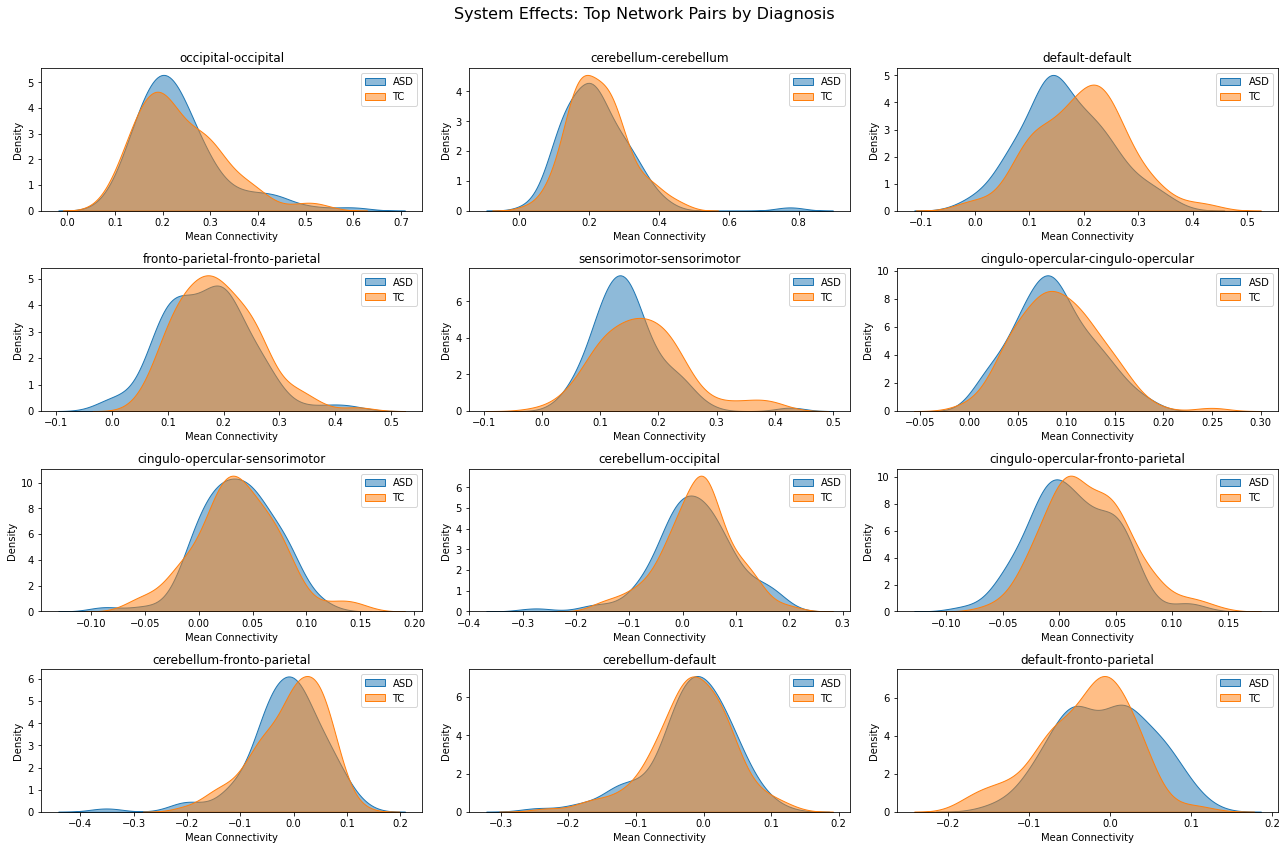

In [ ]:
asd_data_normalized = normalize_by_age(asd_data)
tc_data_normalized = normalize_by_age(tc_data)
    
# 合并两组数据
all_subjects_normalized = asd_data_normalized + tc_data_normalized

# 计算子网络效应
network_df = analyze_system_effects(all_subjects_normalized, networks, roi_info)
plot_system_effects(network_df,m=12)

# 4.边+块